In [18]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

import torch
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

from FaceNeuralNetwork import FaceNeuralNetwork, FaceDataset

### Start Setting ###
data_folder_name = "data_p_B"
device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'models/model_weights_p_B.pth'
loss_fn = nn.MSELoss()
### End Settings ###

meta_data = pd.read_csv(data_folder_name + "/meta_data.csv")

print("Loaded: Total samples={}, Training samples={}, Testing samples={}".format(len(meta_data), (meta_data['testing'] == 0).sum(), (meta_data['testing'] == 1).sum()))

Loaded: Total samples=2412, Training samples=2178, Testing samples=234


In [19]:
print('Using {} device'.format(device))
print('Loading model: {}'.format(model_name))

model = FaceNeuralNetwork().to(device)
checkpoint = torch.load(model_name)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_set = FaceDataset(
    data_folder_name + "/meta_data.csv", 
    data_folder_name + "/raw/",
    device
)
dataloader = DataLoader(data_set, batch_size=1, shuffle=False)

prec = 4
losses = []
x_preds = []
y_preds = []
with torch.no_grad():
    for i, (input_tensor, ground_truth) in enumerate(dataloader):
        pred = model(input_tensor)
        clamped_pred = torch.clamp(pred, min=0.0, max=1.0)
        losses.append(round(loss_fn(pred, ground_truth).item(), prec*2))
        x_preds.append(round(clamped_pred[0][0].item(), prec))
        y_preds.append(round(clamped_pred[0][1].item(), prec))
meta_data['loss'] = losses
meta_data['x_pred'] = x_preds
meta_data['y_pred'] = y_preds

Using cpu device
Loading model: model_weights_p_B.pth


C:\Users\bertr\AppData\Local\Temp/ipykernel_1920/2015394061.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axarr[3,1].hist(least_error_instances[meta_data['testing']==0]['loss'], bins=bins, alpha=alpha)
C:\Users\bertr\AppData\Local\Temp/ipykernel_1920/2015394061.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axarr[4,1].hist(least_error_instances[meta_data['testing']==1]['loss'], bins=bins, alpha=alpha)


(array([2., 3., 2., 1., 0., 2., 1., 1., 3., 0., 2., 2., 2., 2., 0., 3., 1.,
        3., 2., 0., 1., 1., 2., 1., 3., 3., 1., 0., 0., 1., 0., 1., 2., 2.,
        1., 1., 0., 0., 4., 2., 0., 0., 1., 2., 2., 1., 0., 4., 6., 3.]),
 array([4.500000e-07, 1.271580e-05, 2.498160e-05, 3.724740e-05,
        4.951320e-05, 6.177900e-05, 7.404480e-05, 8.631060e-05,
        9.857640e-05, 1.108422e-04, 1.231080e-04, 1.353738e-04,
        1.476396e-04, 1.599054e-04, 1.721712e-04, 1.844370e-04,
        1.967028e-04, 2.089686e-04, 2.212344e-04, 2.335002e-04,
        2.457660e-04, 2.580318e-04, 2.702976e-04, 2.825634e-04,
        2.948292e-04, 3.070950e-04, 3.193608e-04, 3.316266e-04,
        3.438924e-04, 3.561582e-04, 3.684240e-04, 3.806898e-04,
        3.929556e-04, 4.052214e-04, 4.174872e-04, 4.297530e-04,
        4.420188e-04, 4.542846e-04, 4.665504e-04, 4.788162e-04,
        4.910820e-04, 5.033478e-04, 5.156136e-04, 5.278794e-04,
        5.401452e-04, 5.524110e-04, 5.646768e-04, 5.769426e-04,
      

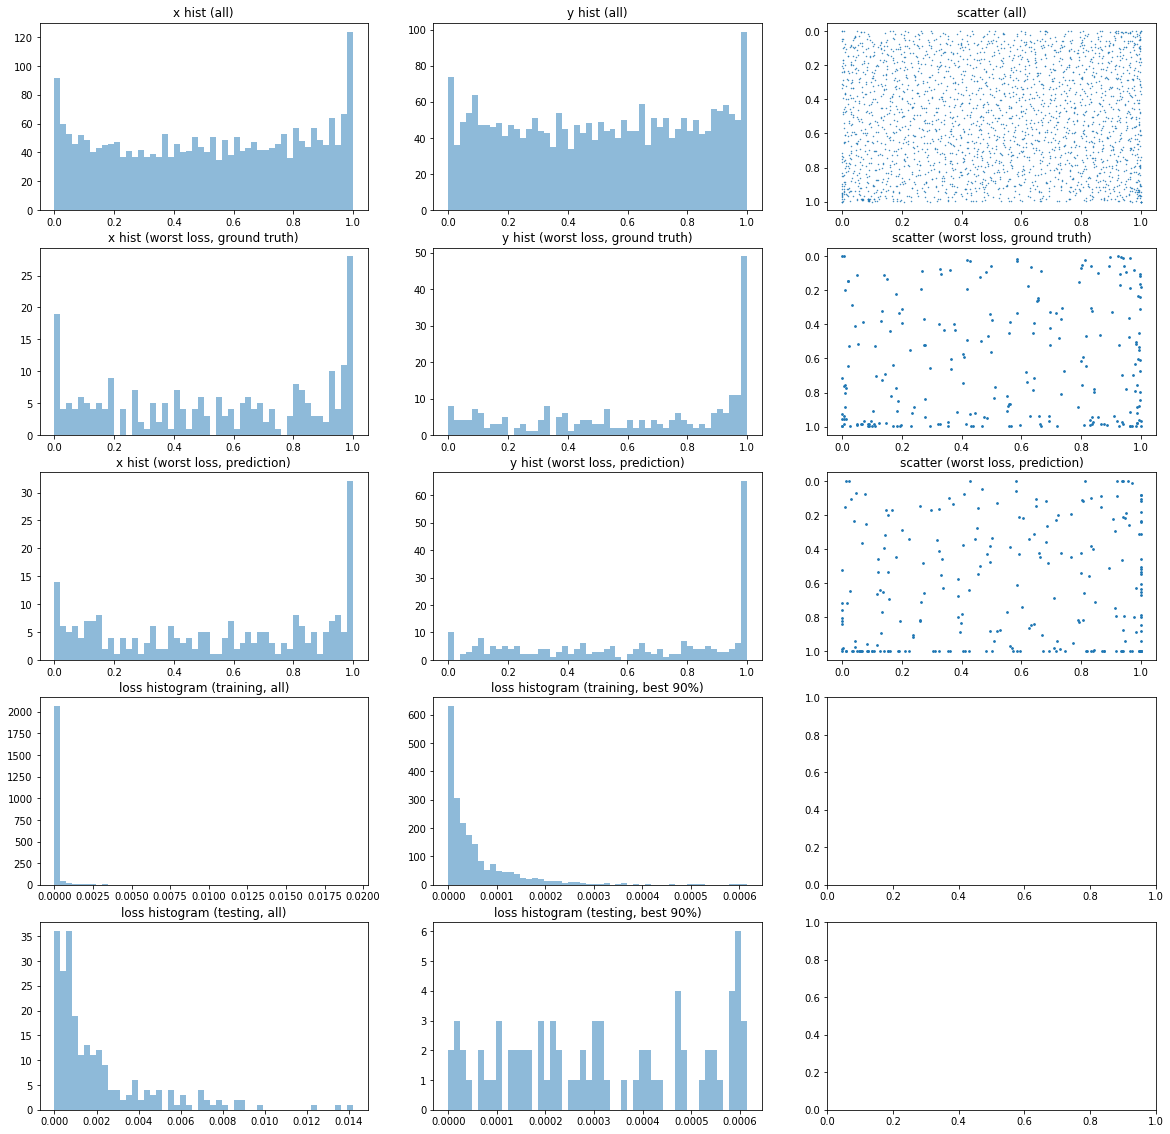

In [30]:
fig, axarr = plt.subplots(5, 3, figsize=(20,20))

bins = 50
alpha = 0.5
dot_size = 0.2

big_losses_mask = meta_data['loss'] >= meta_data['loss'].quantile(0.90)
most_error_instances = meta_data[big_losses_mask]
least_error_instances = meta_data[np.invert(big_losses_mask)]


axarr[0,0].set_title('x hist (all)')
axarr[0,1].set_title('y hist (all)')
axarr[0,2].set_title('scatter (all)')
axarr[0,0].hist(meta_data['x_screen'], bins=bins, alpha=alpha)
axarr[0,1].hist(meta_data['y_screen'], bins=bins, alpha=alpha)
axarr[0,2].invert_yaxis()
axarr[0,2].scatter(meta_data['x_screen'], meta_data['y_screen'], s=dot_size)

axarr[1,0].set_title('x hist (worst loss, ground truth)')
axarr[1,1].set_title('y hist (worst loss, ground truth)')
axarr[1,2].set_title('scatter (worst loss, ground truth)')
axarr[1,0].hist(most_error_instances['x_screen'], bins=bins, alpha=alpha)
axarr[1,1].hist(most_error_instances['y_screen'], bins=bins, alpha=alpha)
axarr[1,2].invert_yaxis()
axarr[1,2].scatter(most_error_instances['x_screen'] , most_error_instances['y_screen'], s=dot_size*15)

axarr[2,0].set_title('x hist (worst loss, prediction)')
axarr[2,1].set_title('y hist (worst loss, prediction)')
axarr[2,2].set_title('scatter (worst loss, prediction)')
axarr[2,0].hist(most_error_instances['x_pred'], bins=bins, alpha=alpha)
axarr[2,1].hist(most_error_instances['y_pred'], bins=bins, alpha=alpha)
axarr[2,2].invert_yaxis()
axarr[2,2].scatter(most_error_instances['x_pred'] , most_error_instances['y_pred'], s=dot_size*15)

axarr[3,0].set_title('loss histogram (training, all)')
axarr[3,1].set_title('loss histogram (training, best 90%)')
axarr[3,0].hist(meta_data[meta_data['testing']==0]['loss'], bins=bins, alpha=alpha)
axarr[3,1].hist(least_error_instances[meta_data['testing']==0]['loss'], bins=bins, alpha=alpha)

axarr[4,0].set_title('loss histogram (testing, all)')
axarr[4,1].set_title('loss histogram (testing, best 90%)')
axarr[4,0].hist(meta_data[meta_data['testing']==1]['loss'], bins=bins, alpha=alpha)
axarr[4,1].hist(least_error_instances[meta_data['testing']==1]['loss'], bins=bins, alpha=alpha)


In [ ]:
from matplotlib.patches import Circle

meta_data_loss_sorted = meta_data.sort_values(by='loss', ascending=False)

print("Worst loss: {}".format(meta_data_loss_sorted['loss'].iloc[0]))
print("best loss: {}".format(meta_data_loss_sorted['loss'].iloc[-1]))

item_count = 10
i = 0
f, axarr = plt.subplots(item_count, 5, figsize=(25,50))
for idx, row in meta_data_loss_sorted[:item_count].iterrows():
    face = data_set.get_face(row)
    text = "idx= {}\nimg= {}\n\nloss= {}\n\npred=({},{})\ngrnd=({},{})".format(idx, row['face_file_name'], row['loss'], row['x_pred'], row['y_pred'], row['x_screen'], row['y_screen'])
    axarr[i,0].text(0.05, 0.5, text, verticalalignment='center')

    left_eye_im, right_eye_im = face.get_eye_im(True), face.get_eye_im(False)
    axarr[i,1].imshow(face.im)
    for k in range(68):
        fx_k, fy_k = row['fx_' + str(k)], row['fy_' + str(k)]
        axarr[i,1].add_patch(Circle((fx_k*face.im.shape[1],fy_k*face.im.shape[0]),1))
    
    axarr[i,2].axis(xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0)
    axarr[i,2].scatter(x=[row['x_pred'], row['x_screen']], y=[row['y_pred'], row['y_screen']], color=['red', 'blue'])
    
    # axarr[i,2].imshow(left_eye_im)
    # axarr[i,3].imshow(right_eye_im)
    
    axarr[i,3].imshow(FaceDataset.pre_process_img(left_eye_im))
    axarr[i,4].imshow(FaceDataset.pre_process_img(right_eye_im))
    
    i += 1